<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
!pip install wandb -qq
import wandb
#from wandb.keras import WandbCallback

     |████████████████████████████████| 1.7 MB 13.9 MB/s 
     |████████████████████████████████| 144 kB 52.9 MB/s 
     |████████████████████████████████| 180 kB 55.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Assignment_1", name="Question 1")

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

In [ ]:
#Load the fashion MNIST data 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

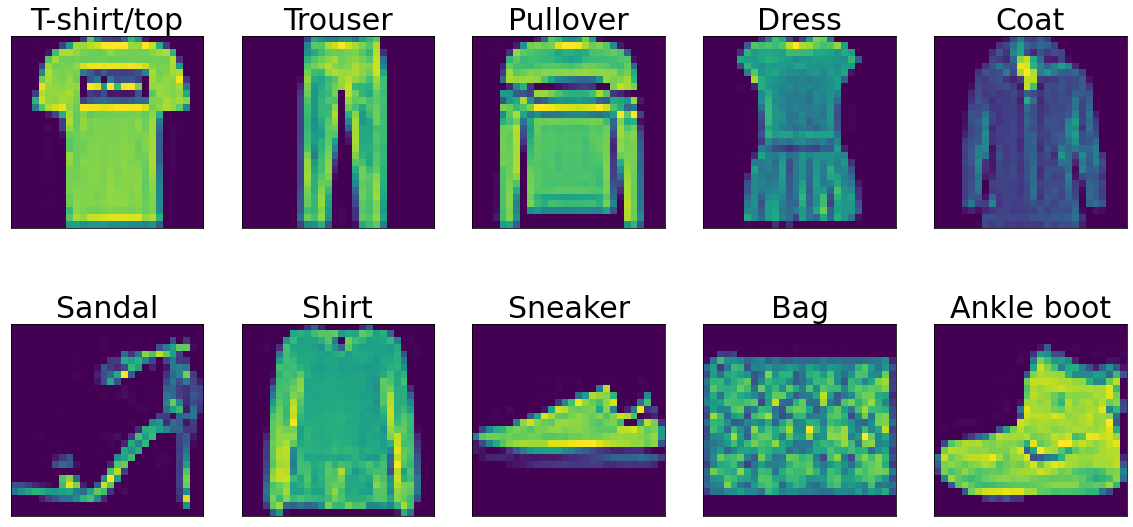

In [ ]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"Samples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [ ]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.





In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, epochs, learning_rate):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.learning_rate = learning_rate
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    nump = np.random.RandomState(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = nump.rand(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))



  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def sigmoid_gradient(self,X):
    #Utility to compute sigmoid function
    #sigmoid = self.sigmoid(X)
    return X*(1-X)

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    # loss= -np.sum(np.sum(Y_true*np.log(Y_pred)))
    # return loss
    yl=np.multiply(Y_pred,Y_true)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def cross_entropy_gradient(self,Y_true,Y_pred):
    #Utility to compute gradient of cross entropy loss
    return -Y_true/(Y_pred)

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def tanh_derivate(self,X):
    # Utility to compute tanh derivative
    return 1 - (np.tanh(X) ** 2)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def relu_derivative(self,X):
    # Utility to compute relu derivative
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    self.H[0] = self.H[0].astype('float128')


    #Compute a(x) = W_x*h(x-1) and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.sigmoid_gradient(self.H[i]), self.dH[i])    
    return


  def gradient_descent(self):
    for i in range(len(self.hidden_layer_sizes)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        self.weights[i+1] = self.weights[i+1] - self.learning_rate * self.dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        self.biases[i+1] = self.biases[i+1] - self.learning_rate * self.db[i+1]
    return 



  def fit(self, X, Y):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}

        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      print("Epoch: ",e," Loss: ",self.cross_entropy(Y, y_preds) )


  def predict(self, X):
    #Find the predictions based on the fitted model
    values = self.forward_propogation(X)
    predictions = self.H[len(self.hidden_layer_sizes)+1]
    return predictions
      


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()

model = FeedForwardNeuralNetwork([100,256, 512], 10, 0.0001)

model.fit(x_train[0:10000], y_encoded[0:10000])

Epoch:  0  Loss:  11.158632878711602577
Epoch:  1  Loss:  56.459906650211561987
Epoch:  2  Loss:  103.18513388453057602
Epoch:  3  Loss:  145.23074438298768855
Epoch:  4  Loss:  178.47091976878302264
Epoch:  5  Loss:  203.24233294268224395
Epoch:  6  Loss:  190.9932346744848967
Epoch:  7  Loss:  194.9111013237063116
Epoch:  8  Loss:  202.96914933221613472
Epoch:  9  Loss:  242.3250418288858484


In [ ]:
#Check predictions for first 10 datapoints
for i in range(10):
  print(model.predict(x_train[i]))
  print(y_encoded[i])


[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Issue might be in sending dw_i to the functions (check call by value or call by reference)

##Question 3

In [ ]:
##Create classes for loss functions
#cross entropy loss

#Create classes for optimizers
#1.SGD
#2.NAG
#3.Momentum
#4.rmsprop
#7.adam
#6.nadam
##Extra:vanilla gd

In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, epochs, optimizer, loss_funtion, activation_function, output_activation):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_funtion = loss_funtion
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    nump = np.random.RandomState(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = nump.rand(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def sigmoid_gradient(self,X):
    #Utility to compute sigmoid function
    #sigmoid = self.sigmoid(X)
    return X*(1-X)

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    # loss= -np.sum(np.sum(Y_true*np.log(Y_pred)))
    # return loss
    yl=np.multiply(Y_pred,Y_true)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def cross_entropy_gradient(self,Y_true,Y_pred):
    #Utility to compute gradient of cross entropy loss
    return -Y_true/(Y_pred)


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    self.H[0] = self.H[0].astype('float128')

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.sigmoid_gradient(self.H[i]), self.dH[i])    
    return


  def fit(self, X, Y):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}

        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, len(self.hidden_layer_sizes))
      #self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      print("Epoch: ",e," Loss: ",self.cross_entropy(Y, y_preds) )


  def predict(self, X):
    #Find the predictions based on the fitted model
    values = self.forward_propogation(X)
    predictions = self.H[len(self.hidden_layer_sizes)+1]
    return predictions
      


In [ ]:
class GD():
  def __init__(self, learning_rate = 0.001):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]

  def update_parameters(self, weights, biases, dw, db, layers):
    for i in range(layers+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases


In [ ]:
class Sigmoid():
  def compute_activation(X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(X):
    #Here X is the activation value
    #sigmoid = compute_activation(X)
    return X*(1-X)

class Softmax():
  def compute_activation(X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(X):
    #Here X is the activation value
    #sigmoid = compute_activation(X)
    return X*(1-X)

In [ ]:
class CrossEntropy():
  def compute_loss(Y_true, Y_pred):
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)
    return loss

  def compute_derivative(Y_pred,Y_true):
    return -Y_true/(Y_pred)

In [ ]:
optimizers = {"gradient_descent":GD()}
loss_functions = {"cross_entropy":CrossEntropy()}
activation_functions = {"sigmoid" = Sigmoid()}

optimizer_gd = optimizers["gradient_descent"]
loss_cross_entropy = loss_functions["cross_entropy"]
activation_sigmoid = activation_functions["sigmoid"]

optimizer_parameters = {"learning_rate":0.00001}
optimizer_gd.set_initial_parameters(optimizer_parameters)

layers = [100,128,64]

model = FeedForwardNeuralNetwork(layers, 10, optimizer_gd, loss_cross_entropy, activation_sigmoid)

model.fit(x_train[0:10000], y_encoded[0:10000])


Epoch:  0  Loss:  11.158632878711602577
Epoch:  1  Loss:  56.459906650211561987
Epoch:  2  Loss:  103.18513388453057602
Epoch:  3  Loss:  145.23074438298768855
Epoch:  4  Loss:  178.47091976878302264
Epoch:  5  Loss:  203.24233294268224395
Epoch:  6  Loss:  190.9932346744848967
